<a href="https://colab.research.google.com/github/ankit-kothari/Data-Science-Journey/blob/master/Natural-Language-Processing/Transformers/Sentiment%20Analysis/airline_tweet_sentiment_analysis/notebooks/airline_tweet_distillBERT_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers 
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv
!pip install dask
!pip install 'fsspec>=0.3.3'


In [ ]:
!pip install datasets
!pip install torchinfo

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Jun 18 16:01:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from transformers import pipeline
import torch
import spacy
import tqdm as notebook_tqdm
from torchinfo import summary
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score,roc_auc_score,accuracy_score
from sklearn.metrics import plot_confusion_matrix,classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import  matplotlib.pyplot as plt
from datasets import load_dataset
from spacy.lang.en import English
import warnings
from tqdm import tqdm
import re
import string
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
import concurrent.futures
import dask.bag as db
import dask 
import graphviz
from dask import visualize

In [ ]:
data = pd.read_csv('./AirlineTweets.csv')
data.head(2)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
data['text'].iloc[0:10]

0                                                                                                         @VirginAmerica What @dhepburn said.
1                                                                    @VirginAmerica plus you've added commercials to the experience... tacky.
2                                                                     @VirginAmerica I didn't today... Must mean I need to take another trip!
3              @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
4                                                                                     @VirginAmerica and it's a really big bad thing about it
5    @VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA
6                                                             @VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)
7     

## Text Preprocessing

In [ ]:
def load_stopwords(filename):
    stopwords = [] 
    with open(filename, "r") as f:
      stopwords = [] 
      for line in tqdm(f):
        line = re.sub(r"\n","",line, flags=re.I)
        stopwords.append(line)
      return set(stopwords)

In [ ]:
stopwords_file = "/content/drive/Shareddrives/MSML641 Project/msml_641_project_scripts/mallet_en_stoplist.txt"
stopwords= load_stopwords(stopwords_file)
nlp = English(parser=False)
def spacy_preprocessing(text):
    '''
    text: accepts stings text
    stopwords: list of stopwords
    proceduralwords: list of procedural words in politics
    exclude_list: Custom list of words to include ex: ['mr','managers']
    clean_tokens: maps words like you're to you are
    returns a clean string

    Parameters
    remove_punctuations: yes removes all puntuations
    remove_stopwords:  yes removes all stopwords
    remove_nonalpha: yes removes all characters execpt uppercase and lowercase letters
    Example: text = text = "I am soooooo excited Mr. , to learn nlp. s123 2003 you're doing      great. He will be awesome!!   managers for life"

    '''
    
    exclude_list=[]
    remove_punctuations='yes'
    remove_stopwords='no'
    remove_nonalpha='yes'

    #removing any websit
    text = re.sub(r"http[s]://[a-zA-Z.\/0-9?=]*\b", "", text)
    # replaces single random characters in the text with space
    text = re.sub(r"\b([a-zA-Z]{1})\b", " ", text)
    # replaces special characters with spaces
    if remove_nonalpha == 'yes':
        text = re.sub(r"[^a-zA-Z]", " ", text)
    # replaces multiple character with a word with one like pooooost will be post
    text = re.sub(r"(.)\1{3,}", r"\1", text)
    # replaces multiple space in the line with single space
    text = re.sub(r"\s{2,}", r" ", text)

    clean_text = []
    
    doc = nlp(text)
    for token in doc:
        if (remove_punctuations == 'yes') & (remove_stopwords == 'yes'):
            if (token.orth_ not in string.punctuation) & (token.orth_.lower() not in stopwords) & (token.orth_.lower() not in exclude_list):
                clean_text.append(token.orth_.lower())
        elif (remove_punctuations == 'yes') & (remove_stopwords == 'no'):
            if (token.orth_ not in string.punctuation):
                clean_text.append(token.orth_.lower())
        elif (remove_punctuations == 'no') & (remove_stopwords == 'yes') & (token.orth_.lower() not in exclude_list):
            if (token.orth_ not in stopwords) & (
                    token.orth_ not in string.punctuation):
                clean_text.append(token.orth_.lower())
        else:
            clean_text.append(token.orth_.lower())
            continue
    clean_string = " ".join(clean_text).lstrip()
    return clean_string

524it [00:00, 1680.96it/s]


In [ ]:
data.shape

(14640, 15)

## Comparing Dask vs Pandas for Text Preprocessing

###Pandas

In [ ]:
%%time
data['clean_lines'] = data['text'].apply(lambda x: spacy_preprocessing(x))

CPU times: user 5.07 s, sys: 25.6 ms, total: 5.1 s
Wall time: 6.51 s


## Dask

In [ ]:
#Convert the list to a Dask bag
reviews_list = data['text'].to_list()
review_bag = db.from_sequence(reviews_list, npartitions=3)


In [ ]:
clean_reviews = review_bag.map(spacy_preprocessing)

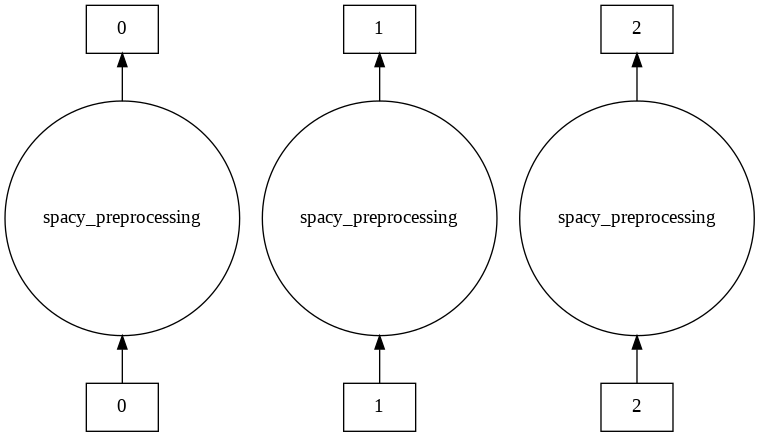

In [ ]:
dask.visualize(clean_reviews)

In [ ]:
%%time
clean_text = clean_reviews.compute()

CPU times: user 971 ms, sys: 70.9 ms, total: 1.04 s
Wall time: 9.7 s


In [ ]:
type(clean_text)

list

## Creating Dataset Object

In [ ]:
data2 = data[['clean_lines','airline_sentiment']]
target_map = {'negative': 0,  'positive': 1,'neutral':2}
data2['label'] = data2['airline_sentiment'].map(target_map)

In [ ]:
import seaborn as sns
label_hist = data['airline_sentiment'].value_counts().reset_index()
label_hist

,index,airline_sentiment
0,negative,9178
1,neutral,3099
2,positive,2363


[]

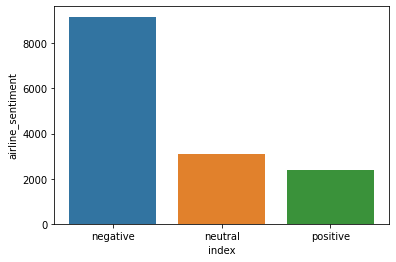

In [ ]:
ax = sns.barplot(x='index',y='airline_sentiment',data=label_hist)
plt.plot()

In [ ]:
data2=data2[['clean_lines','label']]
#targets must have the label name label as per current hugging face documentation
data2.columns = ['sentence','label']
data2.to_csv('/content/drive/MyDrive/data/cleaned_tweets_airline.csv',index = None)


In [ ]:
!head /content/drive/MyDrive/data/cleaned_tweets_airline.csv

sentence,label
virginamerica what dhepburn said,2
virginamerica plus you ve added commercials to the experience tacky,1
virginamerica didn today must mean need to take another trip,2
virginamerica it really aggressive to blast obnoxious entertainment in your guests faces amp they have little recourse,0
virginamerica and it really big bad thing about it,0
virginamerica seriously would pay flight for seats that didn have this playing it really the only bad thing about flying va,0
virginamerica yes nearly every time fly vx this ear worm won go away,1
virginamerica really missed prime opportunity for men without hats parody there,2
virginamerica well didn but now do,1


In [ ]:
#loading custom dataset
raw_datasets = load_dataset('csv',data_files='/content/drive/MyDrive/data/cleaned_tweets_airline.csv') 

In [ ]:
#dataset object
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

In [ ]:
#dataset object has method to split the data into test and train 
split = raw_datasets['train'].train_test_split(test_size=0.3, seed=42)

In [ ]:
#dataset object split in test and train 
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

## Tokenizing 

In [ ]:
from transformers import AutoTokenizer

In [ ]:
checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

### Tokenization the entire dataset

In [ ]:
def tokenize_fn(batch):
  return tokenizer(batch['sentence'], truncation=True) #no padding option since it will be handled by the trainer in thsi case
tokenized_dataset = split.map(tokenize_fn, batched=True)

In [ ]:
print(tokenize_fn(raw_datasets['train'][:3]))

{'input_ids': [[101, 6261, 14074, 14735, 2054, 28144, 13699, 8022, 2056, 102], [101, 6261, 14074, 14735, 4606, 2017, 2310, 2794, 12698, 2000, 1996, 3325, 26997, 2100, 102], [101, 6261, 14074, 14735, 2134, 2651, 2442, 2812, 2342, 2000, 2202, 2178, 4440, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 4392
    })
})

In [ ]:
tokenized_dataset['test']['label'][0:5]

[1, 1, 2, 2, 0]

## Config File

In [ ]:
from transformers import AutoConfig

In [ ]:
#Autoconfig can also be replaced by checkpoint specific configs
config = AutoConfig.from_pretrained(checkpoint)
config

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.20.0",
  "vocab_size": 30522
}

In [ ]:
config.id2label

{0: 'LABEL_0', 1: 'LABEL_1'}

In [ ]:
config.label2id

{'LABEL_0': 0, 'LABEL_1': 1}

In [ ]:
config.id2label = {v:k for k,v in target_map.items()}
config.id2label

{0: 'negative', 1: 'positive', 2: 'neutral'}

In [ ]:
config.label2id = target_map
config.label2id

{'negative': 0, 'neutral': 2, 'positive': 1}

## Modeling

In [ ]:
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification

In [ ]:
from transformers import AutoModelForSequenceClassification
import torch
model_ckpt =  'distilbert-base-uncased'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels=3



In [ ]:
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device))
#Note config and num_labels parameter cannot be passed together

In [ ]:
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              23,440,896
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 66,955,779
Trainable params: 66,955,779
Non-trainable params: 0

##Training Arguments


In [ ]:
batch_size= 16
logging_steps = len(tokenized_dataset["train"]) // batch_size
model_name = "real_airline_tweet_analysis_model"
training_args = TrainingArguments(
    'airline_tweet_lp_real',
    evaluation_strategy='epoch',
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_strategy='epoch',
    logging_steps=logging_steps,
    log_level="error",
    push_to_hub=False,
    disable_tqdm=False
    )

##Custom Metric Function
- Output should always be dictionary with each metric as the key

In [ ]:
def compute_metrics(pred):
  labels=pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels,preds, average="weighted"),
  acc = accuracy_score(labels,preds)
  return {"accuracy":acc,"f1":f1}


## Training 

In [ ]:
from transformers import Trainer 
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=tokenized_dataset['train'],
                  eval_dataset = tokenized_dataset['test'],
                  tokenizer=tokenizer)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.555600,0.446852,0.824681,"(0.8229866760801734,)"
2,0.365100,0.456340,0.833789,"(0.8312770266057654,)"


TrainOutput(global_step=1282, training_loss=0.460062653291244, metrics={'train_runtime': 71.5987, 'train_samples_per_second': 286.262, 'train_steps_per_second': 17.905, 'total_flos': 172370067012432.0, 'train_loss': 0.460062653291244, 'epoch': 2.0})

In [ ]:
tokenized_dataset['train']['input_ids'][0]

[101,
 3915,
 4313,
 14035,
 2435,
 2039,
 2044,
 2062,
 2084,
 2847,
 2006,
 2907,
 2145,
 2342,
 2008,
 24306,
 2197,
 2051,
 2009,
 2001,
 5763,
 2009,
 2196,
 3369,
 2393,
 102]

## Loading in the Checkpoints

In [ ]:
!ls -ltra airline_tweet_lp_real

total 20
drwxr-xr-x 1 root root 4096 Jun 18 16:02 ..
drwxr-xr-x 2 root root 4096 Jun 18 16:03 checkpoint-641
drwxr-xr-x 5 root root 4096 Jun 18 16:03 .
drwxr-xr-x 2 root root 4096 Jun 18 16:03 checkpoint-1282
drwxr-xr-x 4 root root 4096 Jun 18 16:37 runs


## Creating a Pipeline for Prediction

In [ ]:
from transformers import pipeline

In [ ]:
#loading the trained model with a specific checkpoint
savedmodel = pipeline('text-classification',
                      model='airline_tweet_lp_real/checkpoint-1282',
                      device=0)

In [ ]:
#loading the test set
split['test']

Dataset({
    features: ['sentence', 'label'],
    num_rows: 4392
})

In [ ]:
#prediction on test set
test_pred = savedmodel(split['test']['sentence'])

In [ ]:
test_pred[0:2]

[{'label': 'positive', 'score': 0.9276211857795715},
 {'label': 'positive', 'score': 0.9173440933227539}]

In [ ]:
target_map

{'negative': 0, 'neutral': 2, 'positive': 1}

In [ ]:
test_inx = [target_map[k['label']] for k in test_pred]
test_inx[0:2]

[1, 1]

In [ ]:
print(type(test_inx[0]))
print(type(split['test']['label'][0]))

<class 'int'>
<class 'int'>


In [ ]:
cm = confusion_matrix(split['test']['label'], test_inx, labels=[0, 1,2])

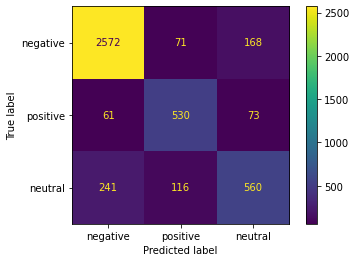

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['negative', 'positive','neutral'])
disp.plot()
plt.grid(False)
plt.show()

In [ ]:
print(classification_report(split['test']['label'], test_labels))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90      2811
           1       0.74      0.80      0.77       664
           2       0.70      0.60      0.65       917

    accuracy                           0.83      4392
   macro avg       0.78      0.77      0.77      4392
weighted avg       0.83      0.83      0.83      4392

